# Импорты

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

import segmentation_models_pytorch as smp

import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from warmup_scheduler import GradualWarmupScheduler

# Гипер параметры

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Классы

In [23]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    comp_dir_path = './data'
    comp_folder_name = ''
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b2'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 0

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'/kaggle/working/outputs/{comp_name}/{exp_name}/'


    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]
    
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

set dataset path


# Функции

In [24]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False
    
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)
        
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [25]:
cfg_init(CFG)
Logger = init_logger(log_file=CFG.log_path)
Logger.info('\n\n-------- exp_info -----------------')



-------- exp_info -----------------


-------- exp_info -----------------


In [26]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        print(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif")
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask


def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [27]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

# Загрузка данных

In [28]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()
valid_xyxys = np.stack(valid_xyxys)

  0%|          | 0/6 [00:00<?, ?it/s]

./data/train/1/surface_volume/29.tif
./data/train/1/surface_volume/30.tif
./data/train/1/surface_volume/31.tif
./data/train/1/surface_volume/32.tif
./data/train/1/surface_volume/33.tif
./data/train/1/surface_volume/34.tif


  0%|          | 0/6 [00:00<?, ?it/s]

./data/train/2/surface_volume/29.tif
./data/train/2/surface_volume/30.tif
./data/train/2/surface_volume/31.tif
./data/train/2/surface_volume/32.tif
./data/train/2/surface_volume/33.tif
./data/train/2/surface_volume/34.tif


  0%|          | 0/6 [00:00<?, ?it/s]

./data/train/3/surface_volume/29.tif
./data/train/3/surface_volume/30.tif
./data/train/3/surface_volume/31.tif
./data/train/3/surface_volume/32.tif
./data/train/3/surface_volume/33.tif
./data/train/3/surface_volume/34.tif


In [29]:
train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [30]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

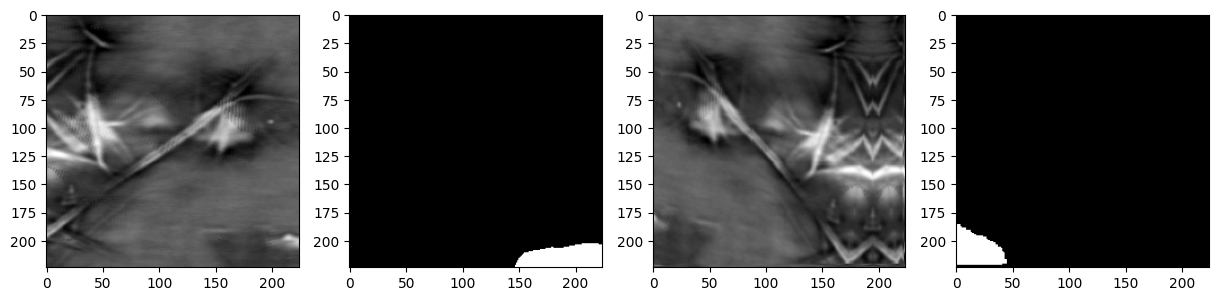

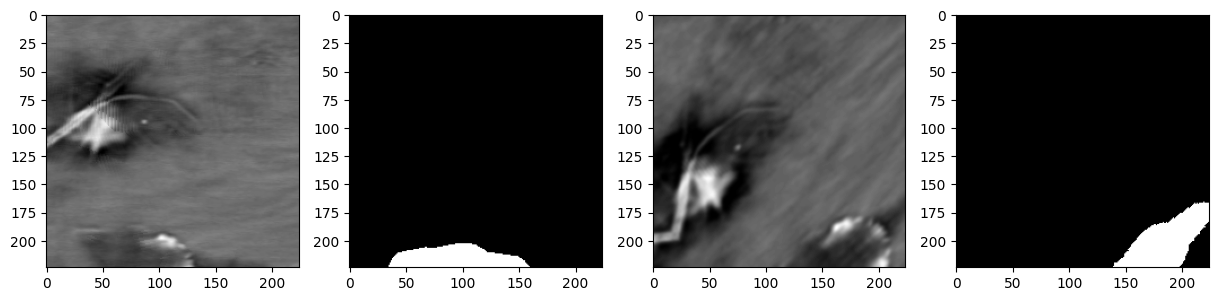

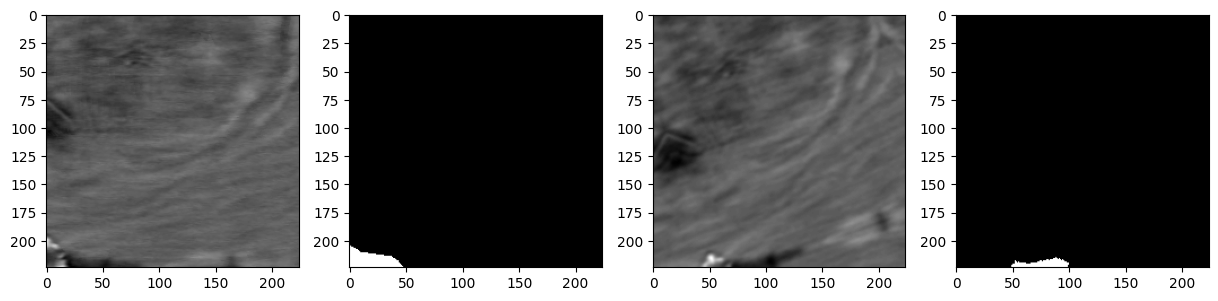

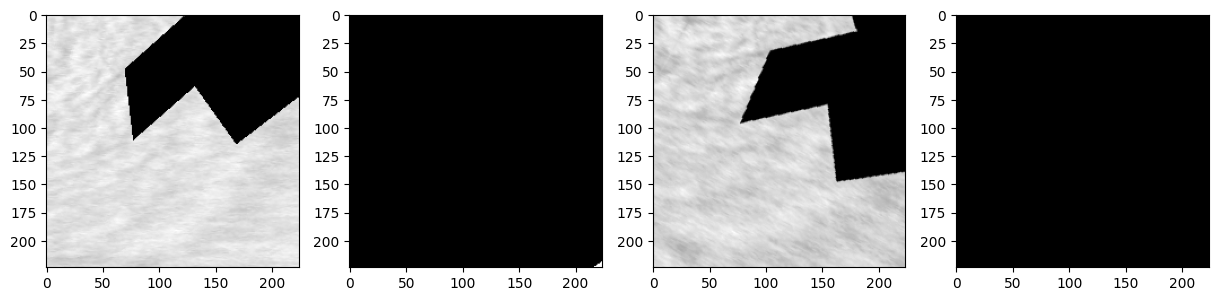

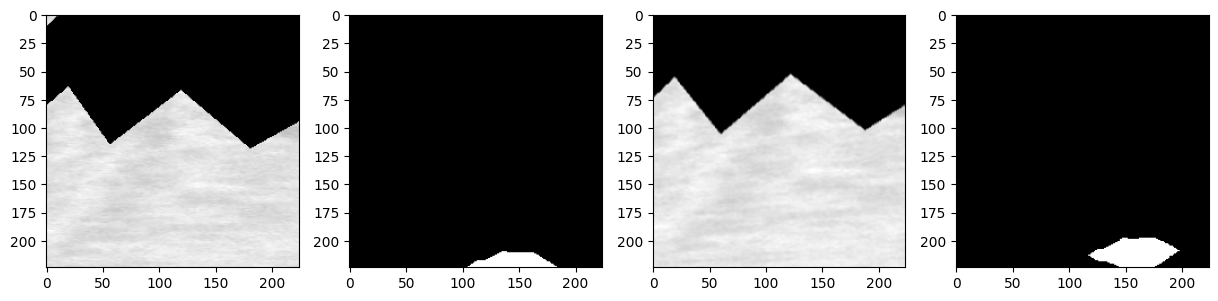

In [31]:
plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [32]:
del plot_dataset
gc.collect()

53842

# Model

In [33]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output
    
def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

model = build_model(CFG)
model.to(device)

model_name Unet
backbone efficientnet-b2


CustomModel(
  (encoder): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        6, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Ide

# Shereduler

In [34]:
def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)

In [35]:
optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

In [36]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

In [37]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

In [38]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

In [39]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [40]:
fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12096878227885388
th: 0.15, fbeta: 0.12095002320763078
th: 0.2, fbeta: 0.12069871592699645
th: 0.25, fbeta: 0.1910564754761271
th: 0.3, fbeta: 0.20962951983703745
th: 0.35, fbeta: 0.21867450808431205
th: 0.4, fbeta: 0.21698374364414436
th: 0.45, fbeta: 0.2047112972714659


best_th: 0.35, fbeta: 0.21867450808431205
best_th: 0.35, fbeta: 0.21867450808431205
Epoch 1 - avg_train_loss: 0.5589  avg_val_loss: 0.4544  time: 226s
Epoch 1 - avg_train_loss: 0.5589  avg_val_loss: 0.4544  time: 226s
Epoch 1 - avgScore: 0.2187
Epoch 1 - avgScore: 0.2187
Epoch 1 - Save Best Score: 0.2187 Model
Epoch 1 - Save Best Score: 0.2187 Model
Epoch 1 - Save Best Loss: 0.4544 Model
Epoch 1 - Save Best Loss: 0.4544 Model


th: 0.5, fbeta: 0.17252729966888222


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12100102065911254
th: 0.15, fbeta: 0.1221198740089144
th: 0.2, fbeta: 0.2131946318964443
th: 0.25, fbeta: 0.22432869709745296
th: 0.3, fbeta: 0.23024882362290158
th: 0.35, fbeta: 0.22730445801091778
th: 0.4, fbeta: 0.2015664346372753
th: 0.45, fbeta: 0.1380087541352514


best_th: 0.3, fbeta: 0.23024882362290158
best_th: 0.3, fbeta: 0.23024882362290158
Epoch 2 - avg_train_loss: 0.4392  avg_val_loss: 0.3701  time: 223s
Epoch 2 - avg_train_loss: 0.4392  avg_val_loss: 0.3701  time: 223s
Epoch 2 - avgScore: 0.2302
Epoch 2 - avgScore: 0.2302
Epoch 2 - Save Best Score: 0.2302 Model
Epoch 2 - Save Best Score: 0.2302 Model
Epoch 2 - Save Best Loss: 0.3701 Model
Epoch 2 - Save Best Loss: 0.3701 Model


th: 0.5, fbeta: 0.06666140925381009


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0


c:\Users\emely\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.26540261980965174
th: 0.15, fbeta: 0.29107936392254746
th: 0.2, fbeta: 0.3109028282975366
th: 0.25, fbeta: 0.32895921195674804
th: 0.3, fbeta: 0.3471251586154527
th: 0.35, fbeta: 0.36490209082005726
th: 0.4, fbeta: 0.38170178766056795
th: 0.45, fbeta: 0.39561849199821647


best_th: 0.5, fbeta: 0.40328287672276375
best_th: 0.5, fbeta: 0.40328287672276375
Epoch 3 - avg_train_loss: 0.2893  avg_val_loss: 0.2644  time: 232s
Epoch 3 - avg_train_loss: 0.2893  avg_val_loss: 0.2644  time: 232s
Epoch 3 - avgScore: 0.4033
Epoch 3 - avgScore: 0.4033
Epoch 3 - Save Best Score: 0.4033 Model
Epoch 3 - Save Best Score: 0.4033 Model
Epoch 3 - Save Best Loss: 0.2644 Model
Epoch 3 - Save Best Loss: 0.2644 Model


th: 0.5, fbeta: 0.40328287672276375


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30917045837933155
th: 0.15, fbeta: 0.33881655551330586
th: 0.2, fbeta: 0.36116377256526266
th: 0.25, fbeta: 0.37910054372586993
th: 0.3, fbeta: 0.39105946225663996
th: 0.35, fbeta: 0.4008542169957831
th: 0.4, fbeta: 0.4067391639586188
th: 0.45, fbeta: 0.40490044052729623


best_th: 0.4, fbeta: 0.4067391639586188
best_th: 0.4, fbeta: 0.4067391639586188
Epoch 4 - avg_train_loss: 0.2455  avg_val_loss: 0.2461  time: 223s
Epoch 4 - avg_train_loss: 0.2455  avg_val_loss: 0.2461  time: 223s
Epoch 4 - avgScore: 0.4067
Epoch 4 - avgScore: 0.4067
Epoch 4 - Save Best Score: 0.4067 Model
Epoch 4 - Save Best Score: 0.4067 Model
Epoch 4 - Save Best Loss: 0.2461 Model
Epoch 4 - Save Best Loss: 0.2461 Model


th: 0.5, fbeta: 0.3900032615559526


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32823288312659643
th: 0.15, fbeta: 0.358424999691084
th: 0.2, fbeta: 0.3782643332777959
th: 0.25, fbeta: 0.40026467738032534
th: 0.3, fbeta: 0.42097487410923257
th: 0.35, fbeta: 0.4378929109100392
th: 0.4, fbeta: 0.4488639321791442
th: 0.45, fbeta: 0.45322200496136084


best_th: 0.45, fbeta: 0.45322200496136084
best_th: 0.45, fbeta: 0.45322200496136084
Epoch 5 - avg_train_loss: 0.2310  avg_val_loss: 0.2477  time: 226s
Epoch 5 - avg_train_loss: 0.2310  avg_val_loss: 0.2477  time: 226s
Epoch 5 - avgScore: 0.4532
Epoch 5 - avgScore: 0.4532
Epoch 5 - Save Best Score: 0.4532 Model
Epoch 5 - Save Best Score: 0.4532 Model
Epoch 5 - Save Best Loss: 0.2477 Model
Epoch 5 - Save Best Loss: 0.2477 Model


th: 0.5, fbeta: 0.4507694873382709


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3413111519308446
th: 0.15, fbeta: 0.3659149650443053
th: 0.2, fbeta: 0.378082946473754
th: 0.25, fbeta: 0.3857710829469424
th: 0.3, fbeta: 0.3925063503447289
th: 0.35, fbeta: 0.3992679009106375
th: 0.4, fbeta: 0.401910111725027
th: 0.45, fbeta: 0.40167765282174167


best_th: 0.4, fbeta: 0.401910111725027
best_th: 0.4, fbeta: 0.401910111725027
Epoch 6 - avg_train_loss: 0.2218  avg_val_loss: 0.2664  time: 221s
Epoch 6 - avg_train_loss: 0.2218  avg_val_loss: 0.2664  time: 221s
Epoch 6 - avgScore: 0.4019
Epoch 6 - avgScore: 0.4019


th: 0.5, fbeta: 0.3999051267942059


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3368323053355091
th: 0.15, fbeta: 0.36201225424795286
th: 0.2, fbeta: 0.3814379405264502
th: 0.25, fbeta: 0.39412495295923144
th: 0.3, fbeta: 0.4019102899485564
th: 0.35, fbeta: 0.4117499376192111
th: 0.4, fbeta: 0.42173744605339614
th: 0.45, fbeta: 0.42652681610368387


best_th: 0.5, fbeta: 0.4273465797512643
best_th: 0.5, fbeta: 0.4273465797512643
Epoch 7 - avg_train_loss: 0.2131  avg_val_loss: 0.2616  time: 235s
Epoch 7 - avg_train_loss: 0.2131  avg_val_loss: 0.2616  time: 235s
Epoch 7 - avgScore: 0.4273
Epoch 7 - avgScore: 0.4273


th: 0.5, fbeta: 0.4273465797512643


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38453345046428206
th: 0.15, fbeta: 0.4041622225246252
th: 0.2, fbeta: 0.41813948853555155
th: 0.25, fbeta: 0.42210957709196095
th: 0.3, fbeta: 0.42227234152156623
th: 0.35, fbeta: 0.41604416101413094
th: 0.4, fbeta: 0.41017957429455043
th: 0.45, fbeta: 0.39903103185693395


best_th: 0.3, fbeta: 0.42227234152156623
best_th: 0.3, fbeta: 0.42227234152156623
Epoch 8 - avg_train_loss: 0.2069  avg_val_loss: 0.2819  time: 227s
Epoch 8 - avg_train_loss: 0.2069  avg_val_loss: 0.2819  time: 227s
Epoch 8 - avgScore: 0.4223
Epoch 8 - avgScore: 0.4223


th: 0.5, fbeta: 0.38003801571482565


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3457400123160211
th: 0.15, fbeta: 0.37081101265178995
th: 0.2, fbeta: 0.3923132738522716
th: 0.25, fbeta: 0.4053952766849874
th: 0.3, fbeta: 0.41609394660433
th: 0.35, fbeta: 0.4282175648327904
th: 0.4, fbeta: 0.4376946125081842
th: 0.45, fbeta: 0.4454709066466842


best_th: 0.5, fbeta: 0.4521824778784856
best_th: 0.5, fbeta: 0.4521824778784856
Epoch 9 - avg_train_loss: 0.2019  avg_val_loss: 0.2611  time: 228s
Epoch 9 - avg_train_loss: 0.2019  avg_val_loss: 0.2611  time: 228s
Epoch 9 - avgScore: 0.4522
Epoch 9 - avgScore: 0.4522


th: 0.5, fbeta: 0.4521824778784856


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3459465128751632
th: 0.15, fbeta: 0.3684673366116561
th: 0.2, fbeta: 0.3869468121205822
th: 0.25, fbeta: 0.4007586733869127
th: 0.3, fbeta: 0.4103364153534127
th: 0.35, fbeta: 0.41974347059351946
th: 0.4, fbeta: 0.4239391773715321
th: 0.45, fbeta: 0.425826829429431


best_th: 0.45, fbeta: 0.425826829429431
best_th: 0.45, fbeta: 0.425826829429431
Epoch 10 - avg_train_loss: 0.1966  avg_val_loss: 0.2705  time: 225s
Epoch 10 - avg_train_loss: 0.1966  avg_val_loss: 0.2705  time: 225s
Epoch 10 - avgScore: 0.4258
Epoch 10 - avgScore: 0.4258


th: 0.5, fbeta: 0.42215780890160204


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3355157301361214
th: 0.15, fbeta: 0.36103292180217295
th: 0.2, fbeta: 0.3794116926777568
th: 0.25, fbeta: 0.39722208427665673
th: 0.3, fbeta: 0.41411062332288084
th: 0.35, fbeta: 0.4243865030720528
th: 0.4, fbeta: 0.4321595055733148
th: 0.45, fbeta: 0.4400578505541931


best_th: 0.5, fbeta: 0.44645426621424295
best_th: 0.5, fbeta: 0.44645426621424295
Epoch 11 - avg_train_loss: 0.1915  avg_val_loss: 0.2648  time: 232s
Epoch 11 - avg_train_loss: 0.1915  avg_val_loss: 0.2648  time: 232s
Epoch 11 - avgScore: 0.4465
Epoch 11 - avgScore: 0.4465


th: 0.5, fbeta: 0.44645426621424295


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3758576519877763
th: 0.15, fbeta: 0.4064640120916837
th: 0.2, fbeta: 0.43111933233732885
th: 0.25, fbeta: 0.45292989642357806
th: 0.3, fbeta: 0.470956973321861
th: 0.35, fbeta: 0.48040874661063404
th: 0.4, fbeta: 0.484542550905592
th: 0.45, fbeta: 0.48279749826213725


best_th: 0.4, fbeta: 0.484542550905592
best_th: 0.4, fbeta: 0.484542550905592
Epoch 12 - avg_train_loss: 0.1861  avg_val_loss: 0.2509  time: 218s
Epoch 12 - avg_train_loss: 0.1861  avg_val_loss: 0.2509  time: 218s
Epoch 12 - avgScore: 0.4845
Epoch 12 - avgScore: 0.4845
Epoch 12 - Save Best Score: 0.4845 Model
Epoch 12 - Save Best Score: 0.4845 Model
Epoch 12 - Save Best Loss: 0.2509 Model
Epoch 12 - Save Best Loss: 0.2509 Model


th: 0.5, fbeta: 0.479526300677601


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36232671112433773
th: 0.15, fbeta: 0.38783391476938617
th: 0.2, fbeta: 0.41033824097807814
th: 0.25, fbeta: 0.4294576397270963
th: 0.3, fbeta: 0.44533107348925083
th: 0.35, fbeta: 0.45747764497981047
th: 0.4, fbeta: 0.46728912576195447
th: 0.45, fbeta: 0.47358751436851865


best_th: 0.5, fbeta: 0.47594123467544536
best_th: 0.5, fbeta: 0.47594123467544536
Epoch 13 - avg_train_loss: 0.1834  avg_val_loss: 0.2613  time: 232s
Epoch 13 - avg_train_loss: 0.1834  avg_val_loss: 0.2613  time: 232s
Epoch 13 - avgScore: 0.4759
Epoch 13 - avgScore: 0.4759


th: 0.5, fbeta: 0.47594123467544536


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36681222294867116
th: 0.15, fbeta: 0.3963072017083218
th: 0.2, fbeta: 0.4191099636037017
th: 0.25, fbeta: 0.4398908743621168
th: 0.3, fbeta: 0.45968266326905655
th: 0.35, fbeta: 0.47461028635858726
th: 0.4, fbeta: 0.48277100790129
th: 0.45, fbeta: 0.484168190252281


best_th: 0.45, fbeta: 0.484168190252281
best_th: 0.45, fbeta: 0.484168190252281
Epoch 14 - avg_train_loss: 0.1790  avg_val_loss: 0.2527  time: 229s
Epoch 14 - avg_train_loss: 0.1790  avg_val_loss: 0.2527  time: 229s
Epoch 14 - avgScore: 0.4842
Epoch 14 - avgScore: 0.4842


th: 0.5, fbeta: 0.4834933837558275


  0%|          | 0/451 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38048508028681066
th: 0.15, fbeta: 0.40877778938107534
th: 0.2, fbeta: 0.4324177324019843
th: 0.25, fbeta: 0.4522679278935574
th: 0.3, fbeta: 0.46930731337365816
th: 0.35, fbeta: 0.482556419386817
th: 0.4, fbeta: 0.4900923404450108
th: 0.45, fbeta: 0.4935433359319479


best_th: 0.5, fbeta: 0.4939799083938555
best_th: 0.5, fbeta: 0.4939799083938555
Epoch 15 - avg_train_loss: 0.1772  avg_val_loss: 0.2598  time: 229s
Epoch 15 - avg_train_loss: 0.1772  avg_val_loss: 0.2598  time: 229s
Epoch 15 - avgScore: 0.4940
Epoch 15 - avgScore: 0.4940
Epoch 15 - Save Best Score: 0.4940 Model
Epoch 15 - Save Best Score: 0.4940 Model
Epoch 15 - Save Best Loss: 0.2598 Model
Epoch 15 - Save Best Loss: 0.2598 Model


th: 0.5, fbeta: 0.4939799083938555


th: 0.1, fbeta: 0.38048508028681066
th: 0.15, fbeta: 0.40877778938107534
th: 0.2, fbeta: 0.4324177324019843
th: 0.25, fbeta: 0.4522679278935574
th: 0.3, fbeta: 0.46930731337365816
th: 0.35, fbeta: 0.482556419386817
th: 0.4, fbeta: 0.4900923404450108
th: 0.45, fbeta: 0.4935433359319479


best_th: 0.5, fbeta: 0.4939799083938555
best_th: 0.5, fbeta: 0.4939799083938555


th: 0.5, fbeta: 0.4939799083938555


(array([38455835.,  3823853.,  2392008.,  1659610.,  1227056.,   998133.,
          848723.,   717595.,   589778.,   500625.,   415007.,   355705.,
          305775.,   281928.,   267479.,   252170.,   221384.,   203286.,
          202971.,   119927.]),
 array([1.87673189e-06, 4.97904844e-02, 9.95790921e-02, 1.49367700e-01,
        1.99156308e-01, 2.48944915e-01, 2.98733523e-01, 3.48522131e-01,
        3.98310738e-01, 4.48099346e-01, 4.97887954e-01, 5.47676561e-01,
        5.97465169e-01, 6.47253777e-01, 6.97042384e-01, 7.46830992e-01,
        7.96619600e-01, 8.46408208e-01, 8.96196815e-01, 9.45985423e-01,
        9.95774031e-01]),
 <BarContainer object of 20 artists>)

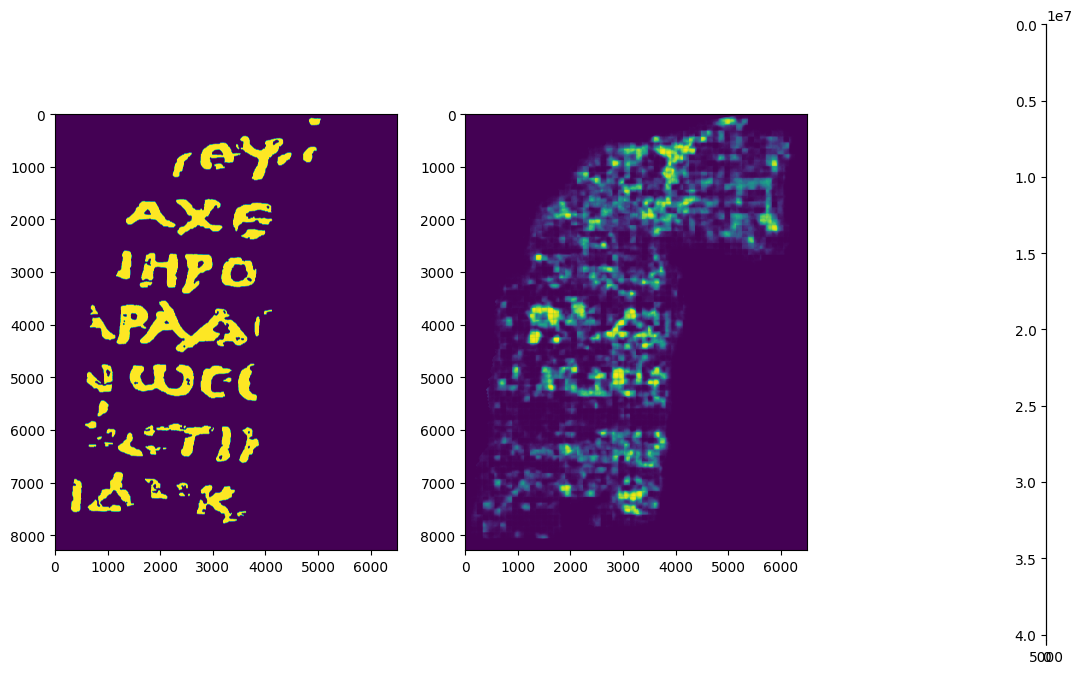

In [41]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

mask_pred = check_point['preds']

best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

plt.hist(mask_pred.flatten(), bins=20)